# Pipelining Everything Together
**Steps:**
1. Upload an image
2. Convert into a grayscale image
3. Crop the face using Haar Cascade Classfier to find coordinates of the face.
4. Normalize the data and resize the image in a standard format.
5. Flatten the image and compute Eigen Image
6. Pass the eigen-image in an SVM
7. Get the output with the confidence score.

In [9]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from glob import glob
from PIL import Image
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC     # Support vector Classifier is also known as Maximum Margin Classifier.
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from skimage import io

**Load the models first**

In [10]:
haar = cv2.CascadeClassifier('haarcascade_classifier.xml')
mean = pickle.load(open('mean_pre_processing.pickle', 'rb'))
model_svm = pickle.load(open('model_svm_ideal.pickle', 'rb'))
model_pca = pickle.load(open('pca_50.pickle', 'rb'))

print("Models loaded successfully..")

Models loaded successfully..


In [11]:
test_data = 'images/test1.jpg'

In [12]:
gender_predict = ['Male', 'Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [14]:
# Step 1 - Load the image
# img = cv2.imread(test_data)

def pipeline_model(img, color='rgb'):
    # Step 2 - Convert to grayscale
    color = 'bgr'
    if color == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else: 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Step 3 - Crop the face using Haar Cascade Classifier

    faces = haar.detectMultiScale(gray, 1.5, 3)
    for x, y, w, h in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)    # Draw Rectangle.
        roi = gray[y:y+h, x:x+w]    # Crop the image.

    # Step 4 - Normalizing the data.
        roi = roi/255.0

    # Resize image
        if roi.shape[1] >= 100:
            roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_AREA)   #SHRINK
        else:
            roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_CUBIC)   # ENLARGE

    # Step 5 - Flatten the data.
        roi_reshape = roi_resize.reshape(1, -1)   

    # Step 6 - Subtract from mean.
        roi_mean = roi_reshape - mean

    # Step 7 - Get Eigen Image using PCA.
        eigen_image = model_pca.transform(roi_mean)

    # Step 8 - Pass to ML SVM Model.
        results = model_svm.predict_proba(eigen_image)[0]

    # Step 9 - Predict
        predict = results.argmax()      # Pick the gender whose probability is highest. returns either 0 or 1
        score = results[predict]

    # Step 10 - Generate result output
        text = "%s : %0.2f"%(gender_predict[predict], score)
        cv2.putText(img, text, (x, y), font, 1, (0, 255, 0), 2)
    return img, predict, score


Male 0.863870803187804


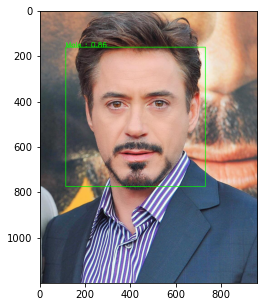

In [17]:
test_data = r"./images/rdj.jpg"
img = Image.open(test_data)
# Convert PIL Image to Cv2 array format using numpy

img = np.array(img)

# Pass to model

img, predict, score = pipeline_model(img)
print(gender_predict[predict], score)
plt.figure(figsize=(15,5))
plt.imshow(img)
# cv2.imshow('Gender Prediction', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Apply pipeline to video:

In [60]:
cap = cv2.VideoCapture('images/testV.mp4')

while True:
    ret, frame = cap.read()
    
    if ret == False:
        break
    
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    frame = pipeline_model(frame, color='bgr')
    
    cv2.imshow('Gender Classification', frame)
    if cv2.waitKey(10) == 27:  # esc key
        break

cv2.destroyAllWindows()
cap.release()